# Volume limited merger fraction with Galaxy Zoo 1 and Galaxy Zoo 2

In this notebook we use Galaxy Zoo 1 (GZ1) and Galaxy Zoo 2 (GZ2) data which has been matched to group data from Yang, calculating merger fractions for group size, stellar mass, halo mass, galaxy velocities and group velocity dispersion.

For this notebook we volume limit our sample of galaxies, keeping the original group size of the non-volume limited group.

The GZ1 and GZ2 data can be found at https://data.galaxyzoo.org/
<br>
Information on Data Release 7 (DR7) of the Sloan Digital Sky Survery (SDSS) can be found at https://classic.sdss.org/dr7/
<br>
The Yang group data can be found at https://gax.sjtu.edu.cn/data/Group.html

#### Data
There are 4 different data sets we are using from the GZ data page. For GZ1 we are using "Table 2", which are galaxies from the entire GZ1 data set with spectra available in SDSS DR7 and "Table 3", which are galaxies from the entire GZ1 data set with no spectra available in SDSS DR7. These have 667,944 and 225,268 galaxies in them respectively.
<br>
For GZ1 we are using "Table 5", which are galaxies from the main GZ2 sample spectroscopic redshifts available in SDSS DR7 and "Table 6", which are galaxies from the main GZ2 sample with only photometric redshifts available in SDSS DR7. These have 243,500 and 42,462 galaxies in them respectively.
<br>
We use Yang Catalogue "PetroC" containing 639,359 galaxies and 473,872 groups.

#### Matching GZ1, GZ2 and Yang
The Yang data set covers redshifts $0.01 \leq z \leq 0.2$, whereas GZ1 and GZ2 cover a greater redshift range. Hence we expect to lose some galaxies when we match the GZ1&2 data to the Yang catalogue. We match the GZ1&2 data to the Yang data by right-ascension (ra) and declination (dec) with a maximum error in position of 5 arcsec, preferentially choosing galaxies with spectra available if both a galaxy from the spectroscopic data and from the photometric data match to the same Yang galaxy.

The total number of matches in Yang for each of the 4 galaxy zoo data sets are:

- GZ1 spectroscopic: 586,594 galaxies
- GZ1 photometric: 42,197 galaxies
- GZ2 spectroscopic: 233,767 galaxies
- GZ2 photometric: 19,451 galaxies

In total there are 628,791 galaxies in Yang with GZ1 data and 253,218 galaxies in Yang with GZ2 data, with 629,365 galaxies from Yang having either GZ1 or GZ2 data and 252,644 galaxies with both GZ1 and GZ2 data.

From now on we shall refer to the Yang group data set of 639,359 galaxies as Yang, and the matched GZ1&2 and Yang data sets as GZ1 and GZ2.

### Importing the data
First we import the necessary packages and import the data into an Astropy Table "all_data".

We display the head of the table to get an idea of what the data looks like.

In [1]:
# from astropy.table import Table
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import .fits data as a table
data_filename = "E:\\MPhys Project\\Main Data\\Group_GZ1_GZ2_full.fits" # All galaxies in group data set with matched GZ1 & Gz2 galaxies

with fits.open(data_filename) as data:
    all_data = Table(data[1].data)

# Display head of data
display(all_data[0:5])

galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,col11 Model,col12 Model,redshift source type,group id,brightest galaxy,most massive galaxy,RA_group,dec_group,z_group,group L_-19.5 log L_odoth2,group stellar mass,halo mass1,halo mass2,mean separation brighter,mean separation massive,f_edge,ID1,ID2,group_size,OBJID_GZ1,RA_GZ1,DEC_GZ1,NVOTE_GZ1,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,U_GZ1,G_GZ1,R_GZ1,I_GZ1,Z_GZ1,UERR_GZ1,GERR_GZ1,RERR_GZ1,IERR_GZ1,ZERR_GZ1,R50_ARCSEC_GZ1,R90_ARCSEC_GZ1,REDSHIFT_GZ1,REDSHIFTERR_GZ1,REDSHIFTCONF_GZ1,MU_GZ1,MG_GZ1,MR_GZ1,MI_GZ1,MZ_GZ1,MUERR_GZ1,MGERR_GZ1,MRERR_GZ1,MIERR_GZ1,MZERR_GZ1,R50_KPC_GZ1,specobjid_GZ2,dr8objid_GZ2,dr7objid_GZ2,ra_GZ2,dec_GZ2,rastring_GZ2,decstring_GZ2,sample_GZ2,gz2class,total_classifications_GZ2,total_votes_GZ2,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t

### Classifying mergers
Many of the galaxies in our data set have classification data from both GZ1 and GZ2. As GZ1 and GZ2 have different decision trees, we must classify mergers in a different way for each. We can then compare the classifications for galaxies which are in both sets, to see if our classification methods are consistent.

For GZ1 we will use the threshold for merger classification as described in [Darg et al. (2009)](https://arxiv.org/pdf/0903.4937.pdf):
- merger weighted vote fraction $p_m$ > 0.4

Note that this was used in Darg et al. (2009) for only galaxies with redshifts $0.005 < z < 0.1$, but we will use it for galaxies in the range $0.1 \leq z \leq 0.2$ here also.

For GZ2 we will use the threshold for merger classification we have done previously:
- "t06_odd_a14_yes_count" $\geq$ 20
- "t06_odd_a14_yes_debiased" > 0.42
- "t08_odd_feature_a24_merger_count" $\geq$ 10
- "t08_odd_feature_a24_merger_debiased" > 0.4

In [2]:
# Create a new column in the data for GZ1 mergers, with a value of 1 if the galaxy is classified as a merger, and 0 if not
all_data_pandas = all_data.to_pandas()
all_data_pandas["GZ1_merger_yes"] = 0
all_data_pandas.loc[all_data_pandas["P_MG"] > 0.4, "GZ1_merger_yes"] = 1

# Do the same for GZ2 mergers
all_data_pandas["GZ2_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ2"] == 1) & (all_data_pandas["t06_odd_a14_yes_count"] >= 20) & (all_data_pandas["t06_odd_a14_yes_debiased"] > 0.42) & (all_data_pandas["t08_odd_feature_a24_merger_count"] >= 10) & (all_data_pandas["t08_odd_feature_a24_merger_debiased"] > 0.4), "GZ2_merger_yes"] = 1

# Return data frame
all_data = Table.from_pandas(all_data_pandas)

# Add column that gives number of merger classifications
all_data["Merger_classifications"] = all_data["GZ1_merger_yes"] + all_data["GZ2_merger_yes"]

### Volume limiting


To volume limit the sample, we need redshifts and absolute magnitudes for each of the galaxies (we are using r-band absolute magnitudes here, $M_r$). We have redshift data from Yang for all galaxies and GZ1 and GZ2 for galaxies with spectra. We also have absolute magnitudes for GZ1 and GZ2 for galaxies with spectra. We have up to three sources for each galaxy, so need to decide which data point to choose.

Spectroscopic redshifts are more accurate than photometric or otherwise derived redshifts, so we will preferentially choose GZ1 and GZ2 spectroscopic redshifts over Yang redshifts, which may not be spectroscopic. GZ2 is a more recent survey than GZ1, so has more recent estimates of redshift and absolute magnitude, so we will preferentially choose GZ2 redshifts and absolute magnitudes over GZ1.
<br>
Note that because estimations of absolute magnitudes in GZ1 and GZ2 require a spectroscopic redshift, only galaxies in either the GZ1 or GZ2 spectroscopic data have values for absolute magnitudes.

This gives the following selection order:

Redshifts:
- If the galaxy has no spectra from GZ1 or GZ2, select redshift from Yang
- If the galaxy has a GZ1 spectra but not GZ2, select GZ1 redshift
- If the galaxy has a GZ2 spectra, select GZ2 redshift

Absolute magnitudes:
- If the galaxy has a GZ1 spectra but not GZ2, select GZ1 absolute magnitude
- If the galaxy has a GZ2 spectra, select GZ2 absolute magnitude

In [3]:
all_data_pandas = all_data.to_pandas()

# Create new column in data for the "best" redshift
all_data_pandas["Best_redshift"] = 0
# If the galaxy has no spectra from GZ1 or GZ2, select redshift from Yang
all_data_pandas.loc[(all_data_pandas["GZ1_SpectroZ"] == 0) & (all_data_pandas["GZ2_SpectroZ"] == 0), "Best_redshift"] = all_data_pandas.loc[(all_data_pandas["GZ1_SpectroZ"] == 0) & (all_data_pandas["GZ2_SpectroZ"] == 0), "z_galaxy"]
# If the galaxy has a GZ1 spectra but not GZ2, select GZ1 redshift
all_data_pandas.loc[(all_data_pandas["GZ1_SpectroZ"] == 1) & (all_data_pandas["GZ2_SpectroZ"] == 0), "Best_redshift"] = all_data_pandas.loc[(all_data_pandas["GZ1_SpectroZ"] == 1) & (all_data_pandas["GZ2_SpectroZ"] == 0), "REDSHIFT_GZ1"]
# If the galaxy has a GZ2 spectra, select GZ2 redshift
all_data_pandas.loc[all_data_pandas["GZ2_SpectroZ"] == 1, "Best_redshift"] = all_data_pandas.loc[all_data_pandas["GZ2_SpectroZ"] == 1, "REDSHIFT_GZ2"]

# Create new column in data for the "best" absolute magnitude in the r band
all_data_pandas.loc[(all_data_pandas["GZ1_SpectroZ"] == 1) | (all_data_pandas["GZ2_SpectroZ"] == 1), "Best_Mr"] = 0
# If the galaxy has a GZ1 spectra but not GZ2, select GZ1 absolute magnitude
all_data_pandas.loc[(all_data_pandas["GZ1_SpectroZ"] == 1) & (all_data_pandas["GZ2_SpectroZ"] == 0), "Best_Mr"] = all_data_pandas.loc[(all_data_pandas["GZ1_SpectroZ"] == 1) & (all_data_pandas["GZ2_SpectroZ"] == 0), "MR_GZ1"]
# If the galaxy has a GZ2 spectra, select GZ2 absolute magnitude
all_data_pandas.loc[all_data_pandas["GZ2_SpectroZ"] == 1, "Best_Mr"] = all_data_pandas.loc[all_data_pandas["GZ2_SpectroZ"] == 1, "PETROMAG_MR_GZ2"]

# Display table of redshifts and absolute magnitudes including new columns
all_data = Table.from_pandas(all_data_pandas)
display(all_data_pandas[["GZ1_SpectroZ", "GZ2_SpectroZ", "z_galaxy", "REDSHIFT_GZ1", "REDSHIFT_GZ2", "Best_redshift", "MR_GZ1", "PETROMAG_MR_GZ2", "Best_Mr"]][0:10])

,GZ1_SpectroZ,GZ2_SpectroZ,z_galaxy,REDSHIFT_GZ1,REDSHIFT_GZ2,Best_redshift,MR_GZ1,PETROMAG_MR_GZ2,Best_Mr
0,1,1,0.054022,0.054011,0.054011,0.054011,-21.040554,-21.041056,-21.041056
1,1,1,0.053818,0.053831,0.053831,0.053831,-20.186768,-20.186756,-20.186756
2,1,1,0.054050,0.054140,0.054140,0.054140,-21.889400,-21.889500,-21.889500
3,0,0,0.138504,NaN,NaN,0.138504,NaN,NaN,NaN
4,1,0,0.128955,0.128931,NaN,0.128931,-21.697758,NaN,-21.697758
5,1,0,0.183435,0.183477,NaN,0.183477,-22.550137,NaN,-22.550137
6,1,0,0.139661,0.139706,NaN,0.139706,-21.876328,NaN,-21.876328
7,1,0,0.139478,0.139541,NaN,0.139541,-21.977560,NaN,-21.977560
8,1,0,0.139322,0.139342,NaN,0.139342,-21.977083,NaN,-21.977083
9,1,0,0.127314,0.127600,NaN,0.127600,-21.796291,NaN,-21.796291


Now that we have selected the best redshift and absolute magnitude, we plot a graph of redshift vs absolute magnitude.

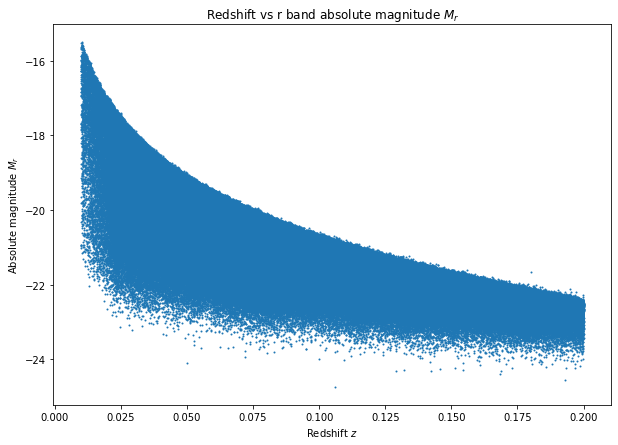

In [4]:
plt.figure(figsize=(10,7))
plt.scatter(all_data_pandas[(all_data_pandas["Best_redshift"] <= 0.2) & (all_data_pandas["Best_redshift"] > 0.01)]["Best_redshift"], all_data_pandas[(all_data_pandas["Best_redshift"] <= 0.2) & (all_data_pandas["Best_redshift"] > 0.01)]["Best_Mr"], s=1)
plt.xlabel("Redshift $z$")
plt.ylabel("Absolute magnitude $M_r$")
plt.title("Redshift vs r band absolute magnitude $M_r$")
plt.show()

From this plot it is clear why we would like to volume limit the sample. The apparent magnitude of a galaxy decreases with redshift, and due to SDSS having a limit below which it cannot see ($m_r > 17.77 \text{ mag}$) we are unable to see fainter galaxies at higher redshifts, we only see the brightest. For example we cannot see any $M_r = -18$ galaxies at redshift $z=0.1$ as these will have apparent magnitudes $m_r>17.77$ and cannot be detected by SDSS.

Because of this, we have a much more complete picture of galaxies at lower redshifts as we know nothing about fainter galaxies at higher redshifts. Volume limiting our sample ensures that we have a complete picture at all redshifts by placing a limit on the absolute magnitude, such that we only see the brightest galaxies at all redshifts.

We want to choose our volume limit such that we are complete at all redshifts that we are interested in, whilst maximising the number of galaxies we keep in our sample.

For now we choose the same limits as done in [Darg et al. (2009)](https://arxiv.org/pdf/0903.4937.pdf), $M_r < -20.55$ and $z < 0.1$.

Number of galaxies in volume limit: 174392
Fraction of spectroscopic galaxies in volume limit: 0.2970437342017946
Fraction of all galaxies in volume limit: 0.2727606868754487
Number of mergers in volume limit: 4550


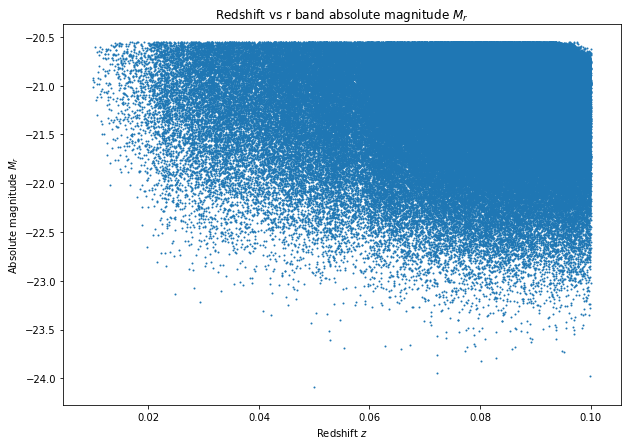

In [5]:
all_data_pandas["volume_limited_sample"] = 0
all_data_pandas.loc[(all_data_pandas["Best_Mr"] < -20.55) & (all_data_pandas["Best_redshift"] < 0.1), "volume_limited_sample"] = 1
print("Number of galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"])))
print("Fraction of spectroscopic galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"]) / len(all_data_pandas[(all_data_pandas["GZ1_SpectroZ"] == 1) | (all_data_pandas["GZ2_SpectroZ"] == 1)])))
print("Fraction of all galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"]) / len(all_data_pandas)))
print("Number of mergers in volume limit: " + str(len(all_data_pandas[(all_data_pandas["volume_limited_sample"] == 1) & (all_data_pandas["Merger_classifications"] >= 1)])))

plt.figure(figsize=(10,7))
plt.scatter(all_data_pandas[all_data_pandas["volume_limited_sample"] == 1]["Best_redshift"], all_data_pandas[all_data_pandas["volume_limited_sample"] == 1]["Best_Mr"], s=1)
plt.xlabel("Redshift $z$")
plt.ylabel("Absolute magnitude $M_r$")
plt.title("Redshift vs r band absolute magnitude $M_r$")
plt.show()

This gives us a complete sample at this redshift, with 174,392 galaxies. To see the new spread of galaxies against redshift, we plot a histogram of redshift.

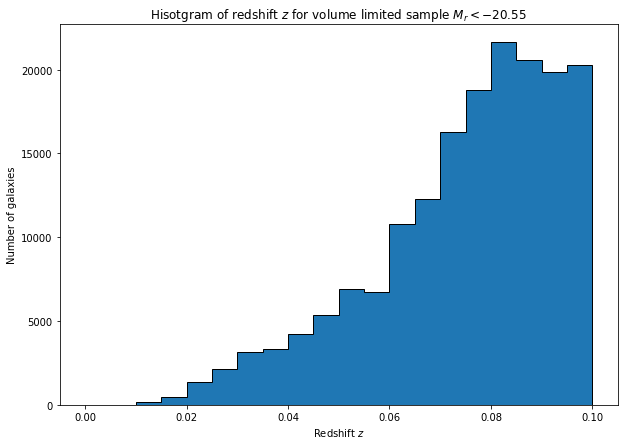

In [6]:
plt.figure(figsize=(10,7))
plt.hist(all_data_pandas[all_data_pandas["volume_limited_sample"] == 1]["Best_redshift"], bins=np.arange(0,0.105,0.005), edgecolor="black", histtype="stepfilled")
plt.xlabel("Redshift $z$")
plt.ylabel("Number of galaxies")
plt.title("Hisotgram of redshift $z$ for volume limited sample $M_r < -20.55$")
plt.show()

Most galaxies are in the redshift range $0.06 < z < 0.1$, and the number of galaxies in each bin generally increases up to a peak at $0.08 < z < 0.085$.

### Group completeness
Now that we have volume limited our sample, we are only interested in groups which have at least one member in the volume limit. If a group is not represented in the volume limit then we have no information about any of its members and should not be included in the following analysis.

We add a column to our data below containing the number of galaxies in each group that are in the volume limited sample and plot a histogram of group size for groups in the volume limit.

In [7]:
volume_limit_groups = all_data_pandas.groupby("group id")["volume_limited_sample"].sum()
volume_limit_groups2 = volume_limit_groups.rename("volume_limited_galaxies_in_group").copy()

all_data_pandas = pd.merge(all_data_pandas, volume_limit_groups2, on="group id", how="left")

,groups,groups N=1,groups N=2,groups N=3,groups N=4,groups N=5,groups N>5
0,135294,106066,16760,5021,2206,1268,3973


,galaxies,groups N=1,groups N=2,groups N=3,groups N=4,groups N=5,groups N>5
0,174392,106066,22314,8766,4854,3439,28953


,galaxies,groups N=1,groups N=2,groups N=3,groups N=4,groups N=5,groups N>5
0,233121,106066,33520,15063,8824,6340,63308


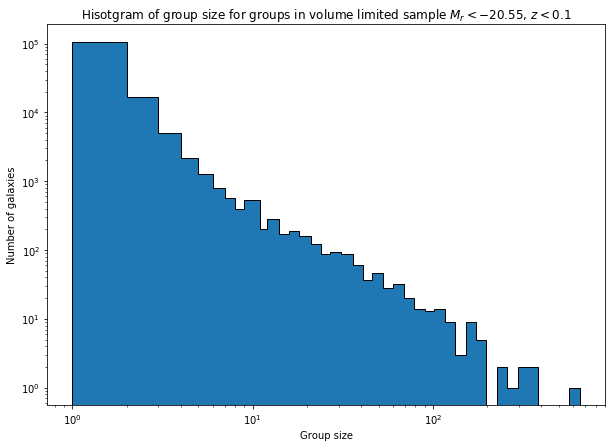

In [8]:
# Create pandas dataframes to allow us to use pandas' groupby function
volume_limited_groups = all_data_pandas[all_data_pandas["volume_limited_galaxies_in_group"] > 0][["galaxy ID", "group_size", "group id"]].copy()
volume_limited_galaxies = all_data_pandas[all_data_pandas["volume_limited_sample"] == 1][["group_size", "galaxy ID"]].copy()

# Group data by group size, then count then unique number of groups and count the number of unique groups
volume_limited_group_counts = volume_limited_groups.groupby("group_size")["group id"].unique().apply(lambda x: len(x))
volume_limited_galaxy_counts = volume_limited_galaxies.groupby("group_size")["galaxy ID"].unique().apply(lambda x: len(x))
volume_limited_total_galaxy_counts = volume_limited_groups.groupby("group_size")["galaxy ID"].unique().apply(lambda x: len(x))

# Create a dataframe and size column, easier to work with
volume_limited_group_counts = pd.DataFrame(volume_limited_group_counts)
volume_limited_group_counts.columns = ["Number of Groups"]
volume_limited_group_counts["size"] = volume_limited_group_counts.index

# Create a dataframe and size column, easier to work with
volume_limited_galaxy_counts = pd.DataFrame(volume_limited_galaxy_counts)
volume_limited_galaxy_counts.columns = ["Number of Galaxies"]
volume_limited_galaxy_counts["size"] = volume_limited_galaxy_counts.index

# Create a dataframe and size column, easier to work with
volume_limited_total_galaxy_counts = pd.DataFrame(volume_limited_total_galaxy_counts)
volume_limited_total_galaxy_counts.columns = ["Number of Galaxies"]
volume_limited_total_galaxy_counts["size"] = volume_limited_total_galaxy_counts.index

# Create a new dataframe to be shown as a table, with the number of groups of a certain size as values
volume_limited_group_counts_df = pd.DataFrame()
volume_limited_group_counts_df.loc[0, "groups"] = sum(volume_limited_group_counts["Number of Groups"])
volume_limited_group_counts_df.loc[0, "groups N=1"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 1]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=2"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 2]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=3"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 3]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=4"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 4]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N=5"] = volume_limited_group_counts[volume_limited_group_counts["size"] == 5]["Number of Groups"].iloc[0]
volume_limited_group_counts_df.loc[0, "groups N>5"] = sum(volume_limited_group_counts[volume_limited_group_counts["size"] > 5]["Number of Groups"])
volume_limited_group_counts_df = volume_limited_group_counts_df.astype(int)

# Create a new dataframe to be shown as a table, with the number of groups of a certain size as values
volume_limited_galaxy_counts_df = pd.DataFrame()
volume_limited_galaxy_counts_df.loc[0, "galaxies"] = sum(volume_limited_galaxy_counts["Number of Galaxies"])
volume_limited_galaxy_counts_df.loc[0, "groups N=1"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 1]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=2"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 2]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=3"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 3]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=4"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 4]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N=5"] = volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] == 5]["Number of Galaxies"].iloc[0]
volume_limited_galaxy_counts_df.loc[0, "groups N>5"] = sum(volume_limited_galaxy_counts[volume_limited_galaxy_counts["size"] > 5]["Number of Galaxies"])
volume_limited_galaxy_counts_df = volume_limited_galaxy_counts_df.astype(int)

# Create a new dataframe to be shown as a table, with the number of groups of a certain size as values
volume_limited_total_galaxy_counts_df = pd.DataFrame()
volume_limited_total_galaxy_counts_df.loc[0, "galaxies"] = sum(volume_limited_total_galaxy_counts["Number of Galaxies"])
volume_limited_total_galaxy_counts_df.loc[0, "groups N=1"] = volume_limited_total_galaxy_counts[volume_limited_total_galaxy_counts["size"] == 1]["Number of Galaxies"].iloc[0]
volume_limited_total_galaxy_counts_df.loc[0, "groups N=2"] = volume_limited_total_galaxy_counts[volume_limited_total_galaxy_counts["size"] == 2]["Number of Galaxies"].iloc[0]
volume_limited_total_galaxy_counts_df.loc[0, "groups N=3"] = volume_limited_total_galaxy_counts[volume_limited_total_galaxy_counts["size"] == 3]["Number of Galaxies"].iloc[0]
volume_limited_total_galaxy_counts_df.loc[0, "groups N=4"] = volume_limited_total_galaxy_counts[volume_limited_total_galaxy_counts["size"] == 4]["Number of Galaxies"].iloc[0]
volume_limited_total_galaxy_counts_df.loc[0, "groups N=5"] = volume_limited_total_galaxy_counts[volume_limited_total_galaxy_counts["size"] == 5]["Number of Galaxies"].iloc[0]
volume_limited_total_galaxy_counts_df.loc[0, "groups N>5"] = sum(volume_limited_total_galaxy_counts[volume_limited_total_galaxy_counts["size"] > 5]["Number of Galaxies"])
volume_limited_total_galaxy_counts_df = volume_limited_total_galaxy_counts_df.astype(int)

# Display tables
display(volume_limited_group_counts_df.style.set_caption("Number of groups in volume limited data:"))
display(volume_limited_galaxy_counts_df.style.set_caption("Total number of galaxies in volume limited groups:"))
display(volume_limited_total_galaxy_counts_df.style.set_caption("Number of galaxies in volume limit:"))

# Create logarithmically spaced bins for logarithmic histogram plot
bin_start = np.log10(min(all_data["group_size"]))
bin_end = np.log10(max(all_data["group_size"]))
num_of_bins = 50
log_bins = np.logspace(bin_start, bin_end, num_of_bins)
log_bins = np.around(log_bins)
log_bins = np.unique(log_bins)

# Plot histogram of group size
groups_unique = all_data_pandas[all_data_pandas["volume_limited_galaxies_in_group"] > 0].drop_duplicates(subset=["group id"], keep="first")  # Only keep 1 row for each group
plt.figure(figsize=(10,7))
plt.hist(groups_unique["group_size"], bins=log_bins, edgecolor="black", histtype="stepfilled")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Group size")
plt.ylabel("Number of galaxies")
plt.title("Hisotgram of group size for groups in volume limited sample $M_r < -20.55$, $z < 0.1$")
plt.show()

After doing this, we can see we have a total of 135,294 groups in our volume limited sample, which contain 233,121 galaxies, of which 174,392 are in the volume limit (they have $M_r < -20.55$ and $z < 0.1$).

We would like to know how complete each group is, i.e. how many galaxies do we have GZ1 or GZ2 data on in the volume limit out of the total number of galaxies in each group. There are now columns in the data containing the group size from Yang and the number of galaxies in the volume limit, so the group completeness for each group is given by
$$\text{group completeness} = \frac{\text{galaxies in volume limit in group}}{\text{galaxies in group}}$$

After computing this for each group, we create a scatter plot of group completeness against group size.

Average completeness of groups N>=3: 0.546
Average completeness of groups N>=10: 0.483
Average completeness of groups N>=30: 0.418


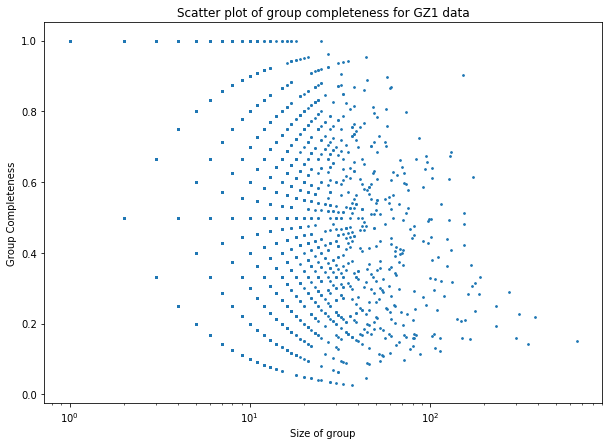

In [9]:
volume_limited_groups = all_data_pandas[all_data_pandas["volume_limited_galaxies_in_group"] > 0].copy()

# Create a new column with the fractional completeness of the group
volume_limited_groups["group_completeness"] = volume_limited_groups["volume_limited_galaxies_in_group"] / volume_limited_groups["group_size"]

# Create a pandas dataframe and group data by size of groups,
# calculating the average completeness for groups greater than a cetain size
groups_unique = volume_limited_groups.drop_duplicates(subset=["group id"], keep="first")  # Only keep 1 row for each group
groups_3_completeness = groups_unique[groups_unique["group_size"] >= 3]["group_completeness"].mean()
groups_10_completeness = groups_unique[groups_unique["group_size"] >= 10]["group_completeness"].mean()
groups_30_completeness = groups_unique[groups_unique["group_size"] >= 30]["group_completeness"].mean()
print("Average completeness of groups N>=3: " + str(np.round(groups_3_completeness, decimals=3)))
print("Average completeness of groups N>=10: " + str(np.round(groups_10_completeness, decimals=3)))
print("Average completeness of groups N>=30: " + str(np.round(groups_30_completeness, decimals=3)))

# Plot a scatter plot of group completeness for all groups in GZ2
plt.figure(figsize=(10,7))
plt.scatter(groups_unique["group_size"], groups_unique["group_completeness"], s=3)
plt.xscale("log")
plt.xlabel("Size of group")
plt.ylabel("Group Completeness")
plt.title("Scatter plot of group completeness for GZ1 data")
plt.show()

On average, groups with $N \geq 3$ have an average group completeness of 0.546, and groups with $N \geq 10$ have an average group completeness of 0.483. We therefore have data on approximately half of the galaxies in each group in our volume limit.

## The merger fraction
Now that we have our volume limited sample, we can calculate the merger fraction as functions of variables in our data. First we will calculate the merger fraction against group size.

In [10]:
volume_limited_data = all_data_pandas[all_data_pandas["volume_limited_galaxies_in_group"] > 0].copy()

### Merger fraction and group size
We will now look at how the merger fraction $f_m$ (the fraction of galaxies that are undergoing mergers) changes with group size for our volume limited sample.

For our mergers, we will use the 4,550 galaxies that are classified in either GZ1 or GZ2, and we will calculate the merger fraction against the 135,294 groups in the volume limited sample, which contain 233,121 galaxies (Note that we only have classification data on 174,392 galaxies).

First we create logarithmically spaced bins that have an (approximately) equal number of galaxies in each bin.

Bins without small groups: [  3   4   7  16  42 652]
Bins with small groups: [  1   2   3   4   7  16  42 652]


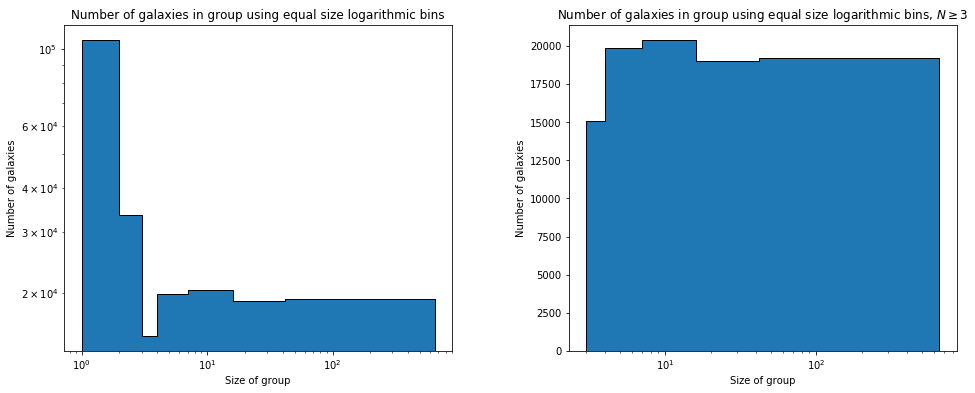

Bootstrapping minimum: [0.01244256 0.03483444 0.03213443 0.02571285 0.02010132 0.01376523
 0.01045276]
Bootstrapping maximum: [0.01327975 0.0371402  0.03502203 0.02826974 0.02187551 0.01557195
 0.01225575]


,Average group size of bin,Merger fraction $f_m$,Galaxies in bin
0,1.000000,0.012916,106066
1,2.000000,0.036008,33520
2,3.000000,0.033725,15063
3,4.794452,0.027038,19898
4,10.066228,0.021061,20369
5,25.604580,0.014688,18995
6,113.960233,0.011400,19210


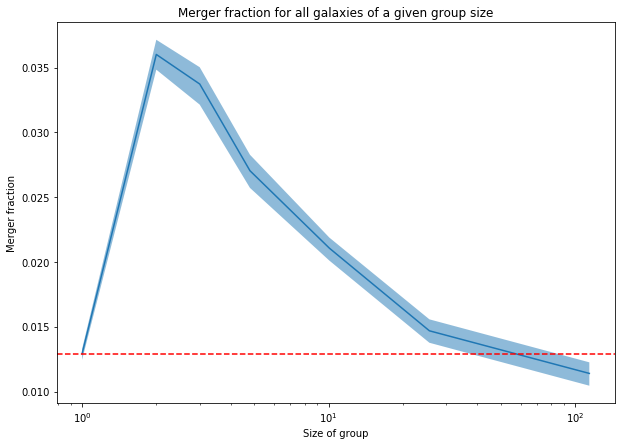

In [11]:
# Create logarithmic bins of equal size without small groups
group_size = volume_limited_data["group_size"]
equal_log_bins = pd.qcut(x=np.log10(group_size[group_size > 2]), q=5, labels=False, retbins=True, duplicates="drop")[1]
equal_log_bins = np.power(10, equal_log_bins)
equal_log_bins = np.round(equal_log_bins, 0)

# Add small groups back into new bins
equal_log_bins_with_small = np.insert(equal_log_bins, [0], 1)
equal_log_bins_with_small = np.insert(equal_log_bins_with_small, [1], 2)
#equal_log_bins_with_small = np.insert(equal_log_bins_with_small, [2], 3)
# equal_log_bins_with_small = np.insert(equal_log_bins_with_small, [3], 4)

# Print the bins that have been calculated
print("Bins without small groups: " + str(equal_log_bins.astype(int)))
print("Bins with small groups: " + str(equal_log_bins_with_small.astype(int)))

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of group size using logarithmic bins
ax[0].hist(group_size, bins=equal_log_bins_with_small, edgecolor="black", histtype="stepfilled")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Size of group")
ax[0].set_ylabel("Number of galaxies")
ax[0].set_title("Number of galaxies in group using equal size logarithmic bins")

# Plot histogram of group size using logarithmic bins for N >= 4
ax[1].hist(group_size, bins=equal_log_bins, edgecolor="black", histtype="stepfilled")
ax[1].set_xscale("log")
# ax[1].set_yscale("log")
ax[1].set_xlabel("Size of group")
ax[1].set_ylabel("Number of galaxies")
ax[1].set_title("Number of galaxies in group using equal size logarithmic bins, $N \geq 3$")

fig.subplots_adjust(wspace=0.3)

plt.show()

def merger_fraction_group_size_bootstrapping(limited_data, group_size_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    limited_data = limited_data[["group_size", "Merger_classifications", "volume_limited_sample"]]
    
    # Calculate number of points for plotting
    number_of_points = len(group_size_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(limited_data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = limited_data.sample(number_for_boostrapping)
        
        # Bin data by group size, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["group_size"], bins=group_size_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[(data_sampled["volume_limited_sample"] == 1) & (data_sampled["Merger_classifications"] > 0) ]["group_size"], bins=group_size_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated logarithmic bins
merger_fraction_group_size_bootstrapped = merger_fraction_group_size_bootstrapping(volume_limited_data, equal_log_bins_with_small, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_group_size_bootstrapped_min = np.amin(merger_fraction_group_size_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_group_size_bootstrapped_max = np.amax(merger_fraction_group_size_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping minimum: " + str(merger_fraction_group_size_bootstrapped_min))
print("Bootstrapping maximum: " + str(merger_fraction_group_size_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_group_size_binning(limited_data, group_size_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["group_size", "Merger_classifications", "volume_limited_sample"]]
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["group_size"], bins=group_size_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[(limited_data["volume_limited_sample"] == 1) & (limited_data["Merger_classifications"] > 0) ]["group_size"], bins=group_size_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["group_size"] >= bin_edges[i]) & (limited_data["group_size"] < bin_edges[i + 1])]["group_size"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_groups, group_size_bin_centres, galaxies_in_bin = merger_fraction_group_size_binning(volume_limited_data, equal_log_bins_with_small)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_groups_info = list(zip(group_size_bin_centres, merger_fraction_groups, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_groups_info, columns=["Average group size of bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(group_size_bin_centres, merger_fraction_groups)
plt.fill_between(group_size_bin_centres, merger_fraction_group_size_bootstrapped_min, merger_fraction_group_size_bootstrapped_max, alpha=0.5)
plt.axhline(y=merger_fraction_groups[0], linestyle="--", c="red")
plt.xscale("log")
plt.xlabel("Size of group")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for all galaxies of a given group size")
plt.show()

### Merger fraction and redshift

Redshift bins: [0.00051879 0.04394103 0.06037246 0.07070284 0.0782968  0.0849993
 0.092383   0.0999996 ]


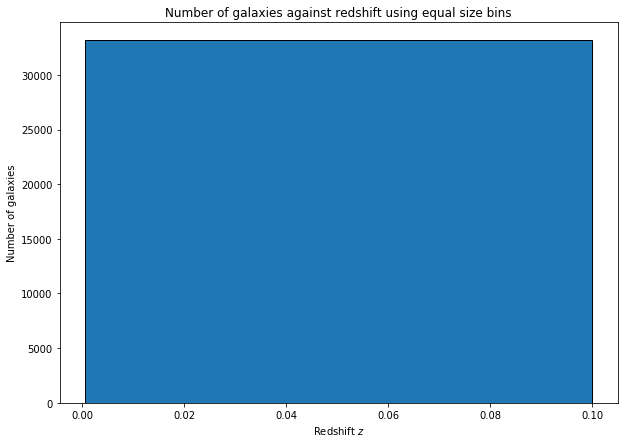

Bootstrapping minimum: [0.01048225 0.01631873 0.02113717 0.02173913 0.02151907 0.02099288
 0.02061959]
Bootstrapping maximum: [0.0115605  0.01756974 0.02235745 0.02312429 0.02253549 0.02282032
 0.02184197]


,Average redshift of bin,Merger fraction $f_m$,Galaxies in bin
0,0.032206,0.011010,33151
1,0.052431,0.016923,33150
2,0.065729,0.021689,33151
3,0.074586,0.022444,33149
4,0.081698,0.021990,33151
5,0.088587,0.021931,33149
6,0.096155,0.021265,33153


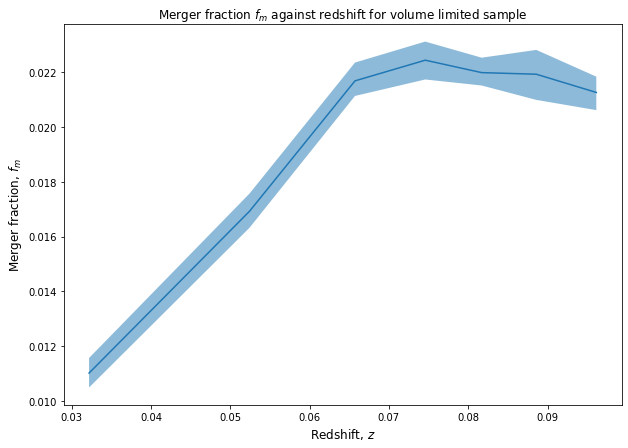

In [12]:
# Create logarithmic bins of equal size without small groups
redshifts = volume_limited_data["Best_redshift"]
redshifts = redshifts[redshifts <= 0.1]
redshift_equal_bins = pd.qcut(redshifts, q=7, labels=False, retbins=True, duplicates="drop")[1]

# Print the bins that have been calculated
print("Redshift bins: " + str(redshift_equal_bins))

# Plot histogram of redshift using equal bins
plt.figure(figsize=(10,7))
plt.hist(redshifts, bins=redshift_equal_bins, edgecolor="black", histtype="stepfilled")
plt.xlabel("Redshift $z$")
plt.ylabel("Number of galaxies")
plt.title("Number of galaxies against redshift using equal size bins")
plt.show()

def merger_fraction_redshift_bootstrapping(limited_data, redshift_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    limited_data = limited_data[["Best_redshift", "Merger_classifications", "volume_limited_sample"]]
    
    # Calculate number of points for plotting
    number_of_points = len(redshift_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(limited_data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = limited_data.sample(number_for_boostrapping)
        
        # Bin data by group size, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["Best_redshift"], bins=redshift_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[(data_sampled["volume_limited_sample"] == 1) & (data_sampled["Merger_classifications"] > 0) ]["Best_redshift"], bins=redshift_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated logarithmic bins
merger_fraction_redshift_bootstrapped = merger_fraction_redshift_bootstrapping(volume_limited_data, redshift_equal_bins, iterations=100, bootstrapping_fraction=0.9)
merger_fraction_redshift_bootstrapped_min = np.amin(merger_fraction_redshift_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_redshift_bootstrapped_max = np.amax(merger_fraction_redshift_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping minimum: " + str(merger_fraction_redshift_bootstrapped_min))
print("Bootstrapping maximum: " + str(merger_fraction_redshift_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_redshift_binning(limited_data, redshift_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["Best_redshift", "Merger_classifications", "volume_limited_sample"]]
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["Best_redshift"], bins=redshift_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[(limited_data["volume_limited_sample"] == 1) & (limited_data["Merger_classifications"] > 0)]["Best_redshift"], bins=redshift_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["Best_redshift"] >= bin_edges[i]) & (limited_data["Best_redshift"] < bin_edges[i + 1])]["Best_redshift"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_redshift = mergersbinned / allbinned
    
    return merger_fraction_redshift, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_redshift, redshift_bin_centres, galaxies_in_bin = merger_fraction_redshift_binning(volume_limited_data, redshift_equal_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_redshift_info = list(zip(redshift_bin_centres, merger_fraction_redshift, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_redshift_info, columns=["Average redshift of bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(redshift_bin_centres, merger_fraction_redshift)
plt.fill_between(redshift_bin_centres, merger_fraction_redshift_bootstrapped_min, merger_fraction_redshift_bootstrapped_max, alpha=0.5)
plt.xlabel("Redshift, $z$", fontsize=12)
plt.ylabel("Merger fraction, $f_m$", fontsize=12)
plt.title("Merger fraction $f_m$ against redshift for volume limited sample", fontsize=12)
plt.show()

### The merger fraction and group stellar mass
Now we investigate how it changes with group stellar mass.

Bins of mass: [ 9.48849964 10.08209991 10.24337978 10.36660004 10.49610043 10.64220047
 10.82040024 11.0703001  11.41380024 11.8451004  12.74009991]


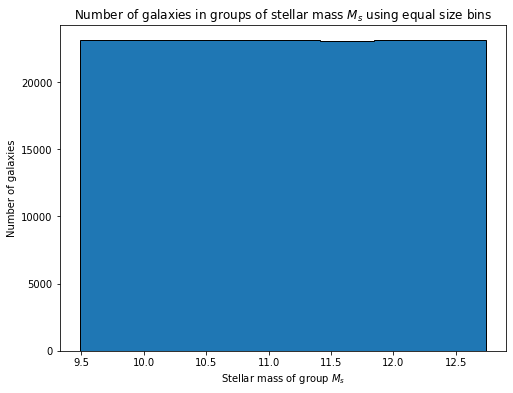

In [13]:
# Create logarithmic bins of equal size without small groups
galaxies_with_stellar_mass = volume_limited_data[volume_limited_data["group stellar mass"] > 0]
equal_bins_mass = pd.qcut(galaxies_with_stellar_mass["group stellar mass"], q=10, labels=False, retbins=True, duplicates="drop")[1]

print("Bins of mass: " + str(equal_bins_mass))

# Plot histogram of group size using logarithmic bins
plt.figure(figsize=(8,6))
plt.hist(galaxies_with_stellar_mass["group stellar mass"], bins=equal_bins_mass, edgecolor="black", histtype="stepfilled")
plt.xlabel("Stellar mass of group $M_s$")
plt.ylabel("Number of galaxies")
plt.title("Number of galaxies in groups of stellar mass $M_s$ using equal size bins")
plt.show()

,Average mass of group in bin,Merger Fraction,Galaxies in bin
0,9.945507,0.014553,23088
1,10.170357,0.013899,23095
2,10.304450,0.016458,23089
3,10.430593,0.022306,23088
4,10.567339,0.031867,23096
5,10.727390,0.040923,23092
6,10.937820,0.054480,23091
7,11.233633,0.049632,23090
8,11.616316,0.036920,23077
9,12.187249,0.031460,23109


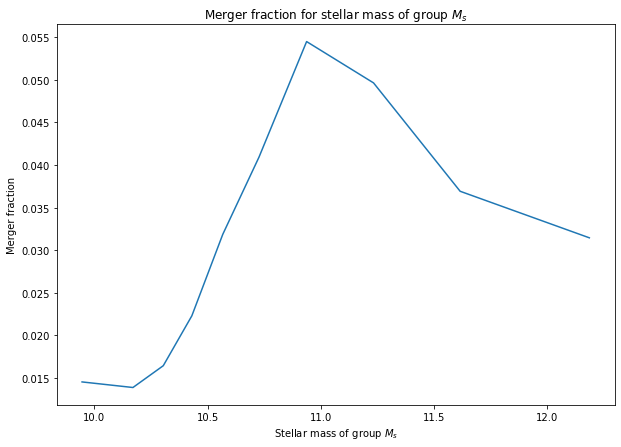

In [14]:
# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_binning(data, mass_bins):
    """Takes data, picks out mergers, returns an array of merger fraction against 
    group size and the centres of each redshift bin for plotting"""
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["group stellar mass"], bins=mass_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["group stellar mass"], bins=mass_bins)
    
    # Calculate the centre of the bins for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["group stellar mass"] >= bin_edges[i]) & (data["group stellar mass"] < bin_edges[i + 1])]["group stellar mass"].mean())
#     bin_centres = bin_edges[:-1]
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

merger_fraction_mass, mass_bin_centres, galaxies_in_bin = merger_fraction_binning(volume_limited_data, equal_bins_mass)

merger_fraction_mass_info = list(zip(mass_bin_centres, merger_fraction_mass, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_mass_info, columns=["Average mass of group in bin", "Merger Fraction", "Galaxies in bin"]))

# Plot a scatter plot of group completeness for all groups in GZ2
plt.figure(figsize=(10,7))
plt.plot(mass_bin_centres, merger_fraction_mass)
# plt.xscale("log")
plt.xlabel("Stellar mass of group $M_s$")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for stellar mass of group $M_s$")
plt.show()

Bins of mass: [11.68089962 11.83100033 11.94069958 12.07689953 12.25020027 12.45930004
 12.73950005 13.13659954 13.62020016 14.11079979 15.1487999 ]


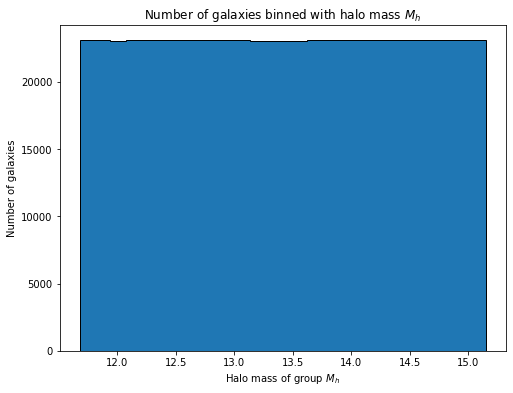

In [15]:
# Create logarithmic bins of equal size without small groups
galaxies_with_halo_mass1 = volume_limited_data[volume_limited_data["halo mass1"] > 0]
equal_bins_halo_mass1 = pd.qcut(galaxies_with_halo_mass1["halo mass1"], q=10, labels=False, retbins=True, duplicates="drop")[1]

print("Bins of mass: " + str(equal_bins_halo_mass1))

# Plot histogram of group size using logarithmic bins
plt.figure(figsize=(8,6))
plt.hist(galaxies_with_halo_mass1["halo mass1"], bins=equal_bins_halo_mass1, edgecolor="black", histtype="stepfilled")
plt.xlabel("Halo mass of group $M_h$")
plt.ylabel("Number of galaxies")
plt.title("Number of galaxies binned with halo mass $M_h$")
plt.show()

,Average halo mass of group in bin,Merger Fraction,Galaxies in bin
0,11.780671,0.010178,23088
1,11.884112,0.013556,23090
2,12.006256,0.016680,23081
3,12.160062,0.024378,23095
4,12.351135,0.033114,23102
5,12.590378,0.045356,23084
6,12.924558,0.053557,23097
7,13.374205,0.048106,23074
8,13.860127,0.036136,23107
9,14.486246,0.031433,23097


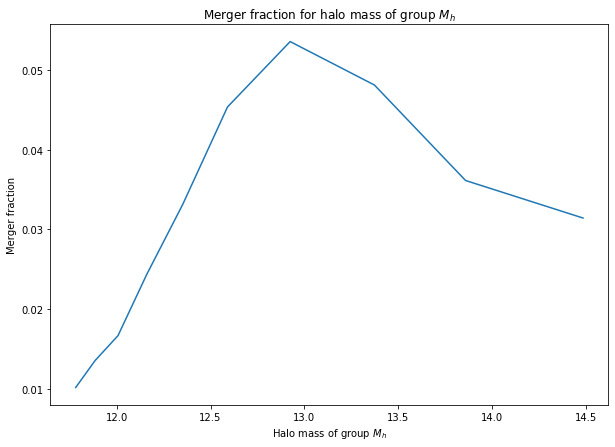

In [16]:
# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_binning(data, mass_bins):
    """Takes data, picks out mergers, returns an array of merger fraction against 
    group size and the centres of each redshift bin for plotting"""
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["halo mass1"], bins=mass_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["halo mass1"], bins=mass_bins)
    
    # Calculate the centre of the bins for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["halo mass1"] >= bin_edges[i]) & (data["halo mass1"] < bin_edges[i + 1])]["halo mass1"].mean())
#     bin_centres = bin_edges[:-1]
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

merger_fraction_halo_mass1, halo_mass1_bin_centres, galaxies_in_bin = merger_fraction_binning(volume_limited_data, equal_bins_halo_mass1)

merger_fraction_halo_mass1_info = list(zip(halo_mass1_bin_centres, merger_fraction_halo_mass1, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_halo_mass1_info, columns=["Average halo mass of group in bin", "Merger Fraction", "Galaxies in bin"]))

# Plot a scatter plot of group completeness for all groups in GZ2
plt.figure(figsize=(10,7))
plt.plot(halo_mass1_bin_centres, merger_fraction_halo_mass1)
# plt.xscale("log")
plt.xlabel("Halo mass of group $M_h$")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for halo mass of group $M_h$")
plt.show()

Bins of mass: [11.75349998 11.87160015 11.98989964 12.12440014 12.29199982 12.5085001
 12.79100037 13.18005037 13.6342001  14.11639977 15.09130001]


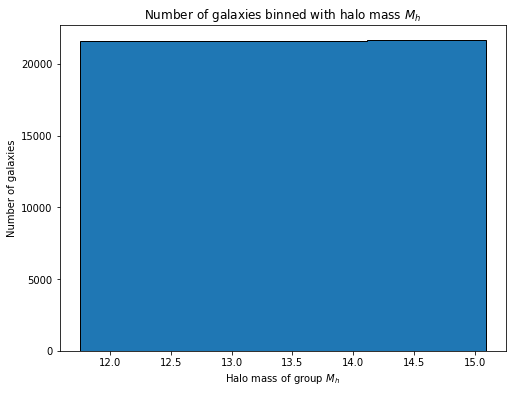

In [17]:
# Create logarithmic bins of equal size without small groups
galaxies_with_halo_mass2 = volume_limited_data[volume_limited_data["halo mass2"] > 0]
equal_bins_halo_mass2 = pd.qcut(galaxies_with_halo_mass2["halo mass2"], q=10, labels=False, retbins=True, duplicates="drop")[1]

print("Bins of mass: " + str(equal_bins_halo_mass2))

# Plot histogram of group size using logarithmic bins
plt.figure(figsize=(8,6))
plt.hist(galaxies_with_halo_mass2["halo mass2"], bins=equal_bins_halo_mass2, edgecolor="black", histtype="stepfilled")
plt.xlabel("Halo mass of group $M_h$")
plt.ylabel("Number of galaxies")
plt.title("Number of galaxies binned with halo mass $M_h$")
plt.show()

,Average halo mass of group in bin,Merger Fraction,Galaxies in bin
0,11.809052,0.013938,21595
1,11.930191,0.014251,21613
2,12.054612,0.018686,21621
3,12.204406,0.025446,21614
4,12.395267,0.035533,21614
5,12.639862,0.044442,21601
6,12.976679,0.056329,21623
7,13.405305,0.047504,21598
8,13.864647,0.035711,21590
9,14.457391,0.031459,21647


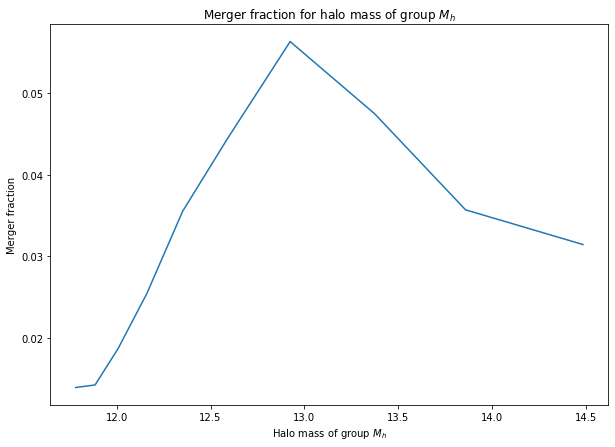

In [18]:
# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_binning(data, mass_bins):
    """Takes data, picks out mergers, returns an array of merger fraction against 
    group size and the centres of each redshift bin for plotting"""
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["halo mass2"], bins=mass_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["halo mass2"], bins=mass_bins)
    
    # Calculate the centre of the bins for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["halo mass2"] >= bin_edges[i]) & (data["halo mass2"] < bin_edges[i + 1])]["halo mass2"].mean())
#     bin_centres = bin_edges[:-1]
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

merger_fraction_halo_mass2, halo_mass2_bin_centres, galaxies_in_bin = merger_fraction_binning(volume_limited_data, equal_bins_halo_mass2)

merger_fraction_halo_mass2_info = list(zip(halo_mass2_bin_centres, merger_fraction_halo_mass2, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_halo_mass2_info, columns=["Average halo mass of group in bin", "Merger Fraction", "Galaxies in bin"]))

# Plot a scatter plot of group completeness for all groups in GZ2
plt.figure(figsize=(10,7))
plt.plot(halo_mass1_bin_centres, merger_fraction_halo_mass2)
# plt.xscale("log")
plt.xlabel("Halo mass of group $M_h$")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for halo mass of group $M_h$")
plt.show()

### The merger fraction and velocities

In [19]:
# Import .fits data as a table
velocities_filename = "E:\\MPhys Project\\Main Data\\velocity_data_yang_redshifts.fits" # All galaxies in group data set with matched GZ1 & Gz2 galaxies

with fits.open(velocities_filename) as data:
    velocity_data_to_merge = Table(data[1].data)

# Crate pandas DataFrames to merge
velocity_data_to_merge_pandas = velocity_data_to_merge.to_pandas()

# Merge the two DataFrames, keeping all the rows in the full DataFrame
merged = pd.merge(all_data_pandas, velocity_data_to_merge_pandas[["galaxy ID", "z_group_mean", "v_i", "velocity_dispersion"]],
                  on="galaxy ID", how="left")
# Display head of data
display(merged.head())
all_data_pandas = merged.copy()

,galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,...,GZ1_merger_yes,GZ2_merger_yes,Merger_classifications,Best_redshift,Best_Mr,volume_limited_sample,volume_limited_galaxies_in_group,z_group_mean,v_i,velocity_dispersion
0,1,750,38.049133,0.224026,0.054022,15.939070,17.620001,0.994186,-20.207098,0.906209,...,0,0,0,0.054011,-21.041056,1,1,NaN,NaN,NaN
1,2,751,38.352526,0.212491,0.053818,16.786047,17.620001,0.987805,-19.363531,0.820707,...,0,0,0,0.053831,-20.186756,0,1,0.053934,-33095.861926,46804.616794
2,3,752,38.363598,0.210654,0.054050,15.090300,17.620001,0.987805,-20.966141,0.758547,...,0,0,0,0.054140,-21.889500,1,1,0.053934,33095.861926,46804.616794
3,4,994,54.450341,0.572606,0.138504,17.604034,17.620001,0.918367,-20.681068,0.880466,...,0,0,0,0.138504,NaN,0,0,NaN,NaN,NaN
4,5,1010,54.534881,0.578615,0.128955,17.415402,17.620001,0.918367,-20.712832,0.918161,...,0,0,0,0.128931,-21.697758,0,0,NaN,NaN,NaN


Velocity bins: [      0.           14804.51265439   32664.25961748   52701.05512867
   76794.09152519  106030.35540818  145044.87821403  200513.85657985
  288008.93898873  450264.81634417 2008639.5313525 ]
Velocity dispersion bins: [     0.          51191.51677958  84580.22593044 116237.71911335
 150238.9181942  193775.26885813 242480.32363795 297486.38776338
 365972.6205263  482579.96507362 795034.32245528]


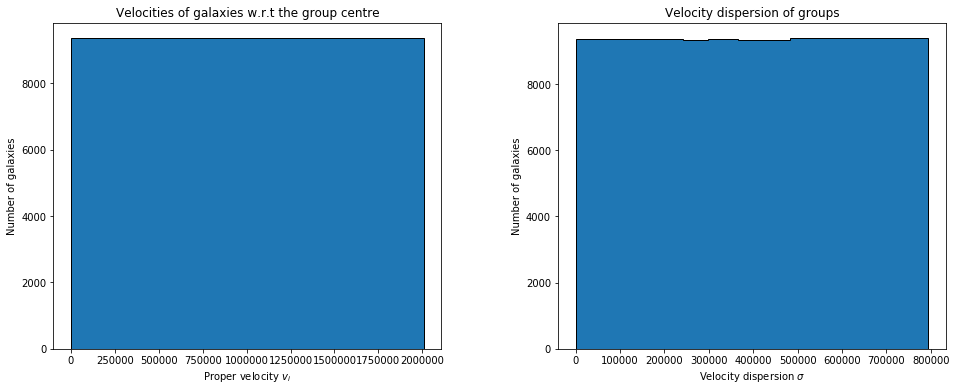

In [20]:
# Create bins of equal size for velocities
volume_limited_data = all_data_pandas[all_data_pandas["volume_limited_galaxies_in_group"] > 0].copy()
velocity_data = volume_limited_data[volume_limited_data["group_size"] >= 3].copy()
velocity_data["v_i"] = abs(velocity_data["v_i"])

velocity_equal_bins = pd.qcut(x=velocity_data["v_i"], q=10, labels=False, retbins=True, duplicates="drop")[1]

velocity_dispersion_equal_bins = pd.qcut(x=velocity_data["velocity_dispersion"], q=10, labels=False, retbins=True, duplicates="drop")[1]

# velocity_equal_log_bins = pd.qcut(x=np.log10(velocity_data["v_i"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_equal_log_bins = np.power(10, equal_log_bins)

# velocity_dispersion_log_bins = pd.qcut(x=np.log10(velocity_data["velocity_dispersion"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_dispersion_equal_log_bins = np.power(10, equal_log_bins)

# Print the bins that have been calculated
print("Velocity bins: " + str(velocity_equal_bins))
print("Velocity dispersion bins: " + str(velocity_dispersion_equal_bins))

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of velocity using velocity bins
ax[0].hist(velocity_data["v_i"], bins=velocity_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[0].set_xscale("log")
#ax[0].set_yscale("log")
ax[0].set_xlabel("Proper velocity $v_i$")
ax[0].set_ylabel("Number of galaxies")
ax[0].set_title("Velocities of galaxies w.r.t the group centre")

# Plot histogram of velocity dispersion using velocity dispersion bins
ax[1].hist(velocity_data["velocity_dispersion"], bins=velocity_dispersion_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel("Velocity dispersion $\sigma$")
ax[1].set_ylabel("Number of galaxies")
ax[1].set_title("Velocity dispersion of groups")

fig.subplots_adjust(wspace=0.3)

plt.show()

Bootstrapping velocity minimum: [0.02890242 0.02482185 0.02247325 0.02416775 0.01882102 0.02202748
 0.01747504 0.01490242 0.01247179 0.0121791 ]
Bootstrapping velocity maximum: [0.03181387 0.02743794 0.02531796 0.02667464 0.02132449 0.02454426
 0.019678   0.01737475 0.01455966 0.01377509]


,Average galaxy velocity in bin,Merger fraction $f_m$,Galaxies in bin
0,6600.492369,0.030361,9354
1,23547.671420,0.026091,9352
2,42382.750506,0.023838,9355
3,64267.716650,0.025446,9353
4,90768.231487,0.020207,9353
5,124446.100692,0.023519,9354
6,171042.394774,0.018713,9352
7,240908.651230,0.016248,9355
8,359166.105227,0.013579,9353
9,690011.934339,0.012936,9354


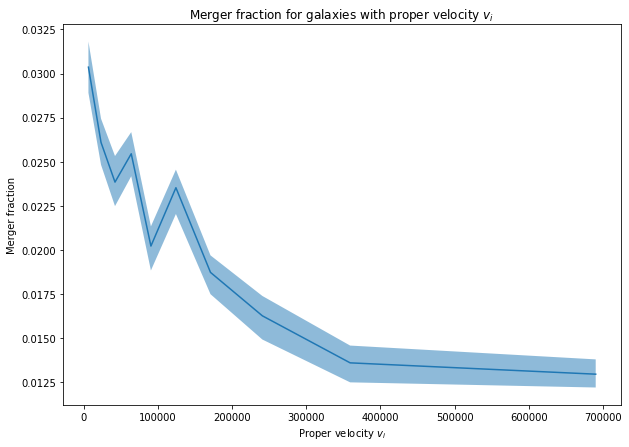

In [23]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["v_i", "Merger_classifications", "volume_limited_sample"]].copy()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    # Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocities, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["v_i"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[(data_sampled["volume_limited_sample"] == 1) & (data_sampled["Merger_classifications"] > 0)]["v_i"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity bins
velocity_data_pandas = velocity_data.copy()
merger_fraction_velocity_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data_pandas, velocity_equal_bins, iterations=100, bootstrapping_fraction=0.9)
merger_fraction_velocity_bootstrapped_min = np.amin(merger_fraction_velocity_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_bootstrapped_max = np.amax(merger_fraction_velocity_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity minimum: " + str(merger_fraction_velocity_bootstrapped_min))
print("Bootstrapping velocity maximum: " + str(merger_fraction_velocity_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against galaxy velocities
def merger_fraction_velocity_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocities,
    the average velocity of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    data = data[["v_i", "Merger_classifications", "volume_limited_sample"]]
    
    # Bin data by velocity, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["v_i"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[(data["volume_limited_sample"] == 1) & (data["Merger_classifications"] > 0)]["v_i"], bins=velocity_bins)
    
    # Calculate the average velocity in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["v_i"] >= bin_edges[i]) & (data["v_i"] < bin_edges[i + 1])]["v_i"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated velocity bins
merger_fraction_velocities, velocity_bin_centres, galaxies_in_bin = merger_fraction_velocity_binning(velocity_data_pandas, velocity_equal_bins)

# Create dataframe of average galaxy velocity, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_info = list(zip(velocity_bin_centres, merger_fraction_velocities, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_velocity_info, columns=["Average galaxy velocity in bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_bin_centres, merger_fraction_velocities)
plt.fill_between(velocity_bin_centres, merger_fraction_velocity_bootstrapped_min, merger_fraction_velocity_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlabel("Proper velocity $v_i$")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for galaxies with proper velocity $v_i$")
plt.show()

Bootstrapping velocity dispersion minimum: [0.02869048 0.02341893 0.02534809 0.02390865 0.02066754 0.01855155
 0.01498573 0.01725564 0.01288629 0.01092896]
Bootstrapping velocity dispersion maximum: [0.03271642 0.02640382 0.02831985 0.02665551 0.02379543 0.02030578
 0.01683861 0.01961488 0.0147989  0.01312522]


,Average group velocity dispersion in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,27282.205751,0.031003,9354,2779
1,68104.500382,0.025235,9352,2374
2,100123.125107,0.027261,9354,2040
3,132630.311575,0.025348,9350,1694
4,171492.973035,0.022239,9353,1343
5,217732.164139,0.019459,9353,903
6,269263.992637,0.015956,9338,612
7,331328.265649,0.018370,9363,390
8,414725.358179,0.013932,9331,250
9,580319.905825,0.012144,9387,83


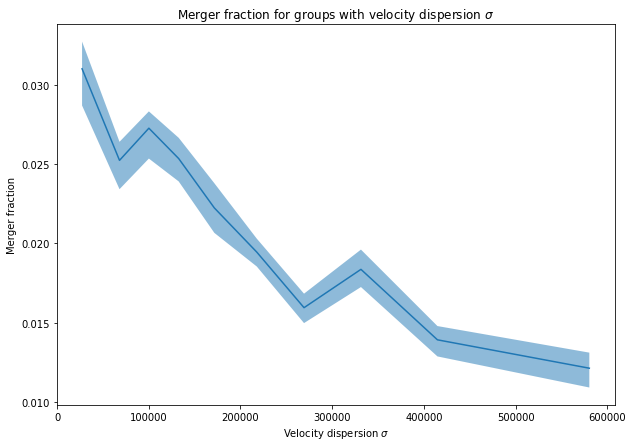

In [24]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["velocity_dispersion", "Merger_classifications", "volume_limited_sample"]].copy()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocity dispersion, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["velocity_dispersion"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[(data_sampled["volume_limited_sample"] == 1) & (data_sampled["Merger_classifications"] > 0)]["velocity_dispersion"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data_pandas, velocity_dispersion_equal_bins, iterations=100, bootstrapping_fraction=0.9)
merger_fraction_velocity_dispersion_bootstrapped_min = np.amin(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_dispersion_bootstrapped_max = np.amax(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity dispersion minimum: " + str(merger_fraction_velocity_dispersion_bootstrapped_min))
print("Bootstrapping velocity dispersion maximum: " + str(merger_fraction_velocity_dispersion_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against velocity dispersion
def merger_fraction_velocity_dispersion_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocity dispersion,
    the average velocity dispersion of galaxies in bin for plotting and the number
    of galaxies and groups in each bin."""
    
    # Resample table with only the data needed
    data = data[["velocity_dispersion", "Merger_classifications", "group id", "volume_limited_sample"]].copy()
    
    # Create subset with only one representative per group
    groups_unique = data.drop_duplicates(subset=["group id"], keep="first")
    
    # Bin data by velocity dispersion, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["velocity_dispersion"], bins=velocity_bins)
    groupsbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[(data["volume_limited_sample"] == 1) & (data["Merger_classifications"] > 0)]["velocity_dispersion"], bins=velocity_bins)
    
    # Calculate the average velocity dispersion in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["velocity_dispersion"] >= bin_edges[i]) & (data["velocity_dispersion"] < bin_edges[i + 1])]["velocity_dispersion"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion, velocity_dispersion_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_velocity_dispersion_binning(velocity_data_pandas, velocity_dispersion_equal_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_dispersion_info = list(zip(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion, galaxies_in_bin, groups_in_bin))
display(pd.DataFrame(merger_fraction_velocity_dispersion_info, columns=["Average group velocity dispersion in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion)
plt.fill_between(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion_bootstrapped_min, merger_fraction_velocity_dispersion_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlabel("Velocity dispersion $\sigma$")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for groups with velocity dispersion $\sigma$")
plt.show()